In [11]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import cv2 as cv
import os
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras import regularizers

In [12]:
np.random.seed(42)

In [13]:
os.listdir('./orl')

['s1',
 's10',
 's11',
 's12',
 's13',
 's14',
 's15',
 's16',
 's17',
 's18',
 's19',
 's2',
 's20',
 's21',
 's22',
 's23',
 's24',
 's25',
 's26',
 's27',
 's28',
 's29',
 's3',
 's30',
 's31',
 's32',
 's33',
 's34',
 's35',
 's36',
 's37',
 's38',
 's39',
 's4',
 's40',
 's5',
 's6',
 's7',
 's8',
 's9']

In [14]:
DATADIR = r'./orl'

In [15]:
CATEGORIES = os.listdir(DATADIR)
CATEGORIES

['s1',
 's10',
 's11',
 's12',
 's13',
 's14',
 's15',
 's16',
 's17',
 's18',
 's19',
 's2',
 's20',
 's21',
 's22',
 's23',
 's24',
 's25',
 's26',
 's27',
 's28',
 's29',
 's3',
 's30',
 's31',
 's32',
 's33',
 's34',
 's35',
 's36',
 's37',
 's38',
 's39',
 's4',
 's40',
 's5',
 's6',
 's7',
 's8',
 's9']

In [16]:
def load_data():
    DATADIR = r'./orl'
    data = []
    # loading training data
    for category in CATEGORIES:
        # create path to image of respective indivudus
        path = os.path.join(DATADIR, category)
        # get the classification  for each indivudus 
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img), 0)
            data.append([img_array, class_num])
            
    return data

In [17]:
data = load_data()

100%|██████████| 10/10 [00:00<00:00, 204.04it/s]


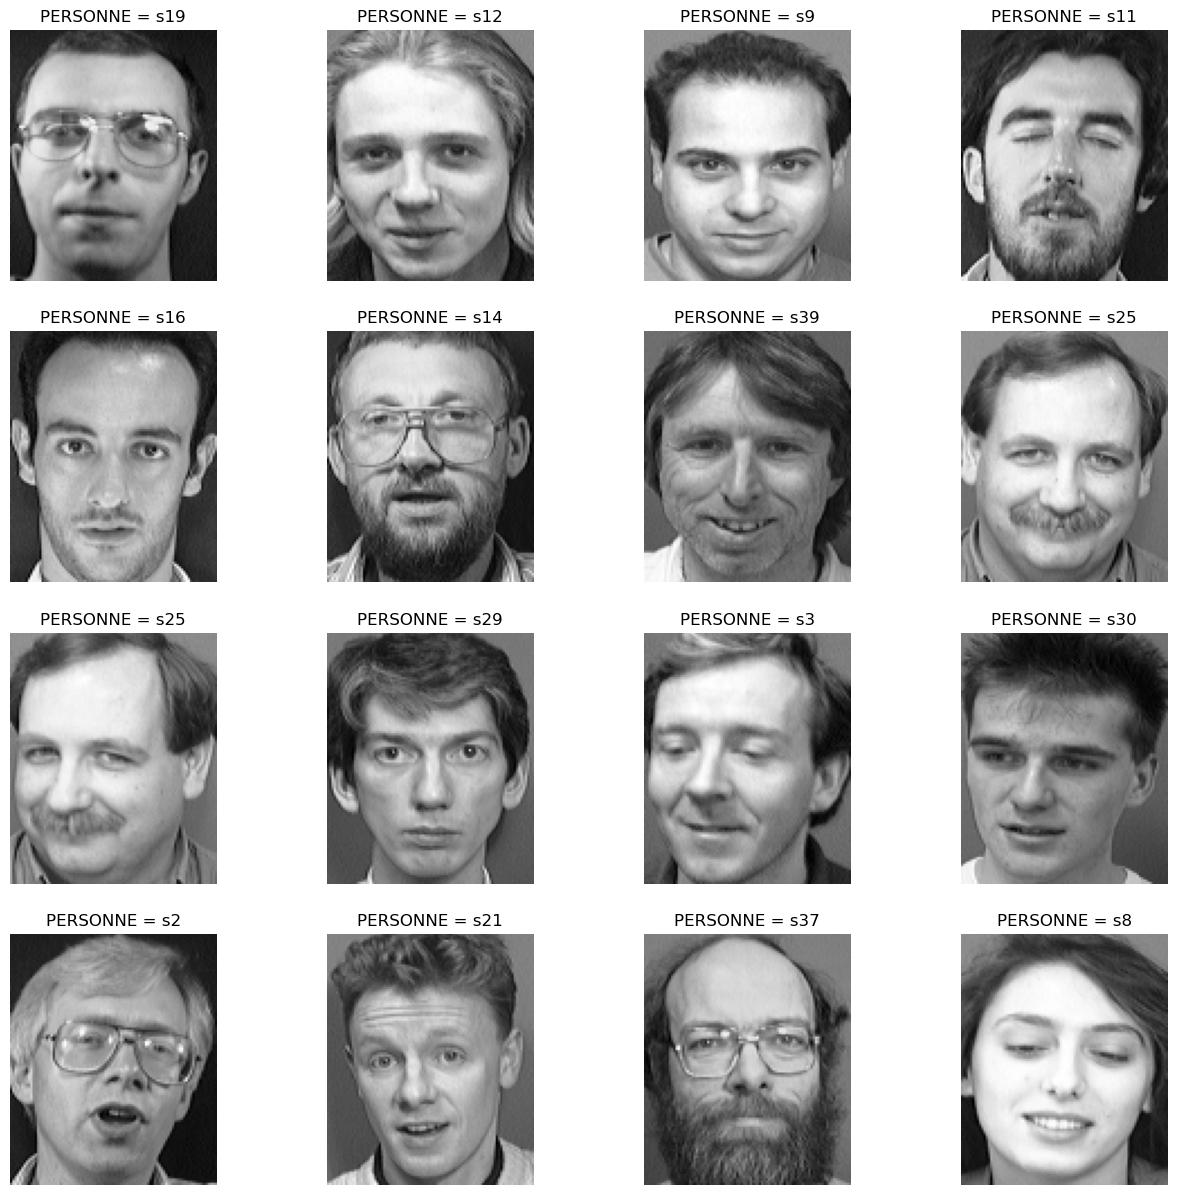

In [18]:
L = 4
W = 4
fig, axes = plt.subplots(L, W, figsize = (15,15))
axes = axes.ravel()

for i in range(0, L * W):  
    sample = random.choice(data)
    axes[i].set_title("PERSONNE = "+str(CATEGORIES[sample[1]]))
    axes[i].imshow(sample[0], cmap='gray')
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

In [19]:
X = np.array([ x[0] for x in data])
y = np.array([Y[1] for Y in data])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

In [21]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("-------------------------------")
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (320, 112, 92)
y_train shape:  (320,)
-------------------------------
X_test shape:  (80, 112, 92)
y_test shape:  (80,)


In [22]:
# remodeler y_train et y_test
y_train = np.reshape(y_train, (len(y_train),1))
y_test  = np.reshape(y_test , (len(y_test ),1))

print("After reshaping")
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

After reshaping
y_train shape:  (320, 1)
y_test shape:  (80, 1)


In [23]:
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

print("After adding color channel")
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

After adding color channel
X_train shape:  (320, 112, 92, 1)
X_test shape:  (80, 112, 92, 1)


In [24]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [25]:
y_train[0]

array([0])

In [26]:
y_train_SVM = y_train
y_test_SVM = y_test

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
y_train[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

In [27]:
y_train.shape, y_test.shape

((320, 40), (80, 40))

In [57]:
def create_model(input_shape=None):
    if input_shape is None :
        input_shape=(48,48,1)
        model = Sequential()
        model.add(Conv2D(16, (3, 3), input_shape=input_shape, padding='same', activation = 'relu'))
        model.add(MaxPool2D(pool_size=(2, 2)))

        model.add(Conv2D(32, (3, 3), padding='same', activation = 'relu'))
        model.add(MaxPool2D(pool_size=(2, 2)))

        model.add(Conv2D(64, (3, 3), activation = 'relu'))
        model.add(MaxPool2D(pool_size=(2, 2)))

        model.add(Flatten())
        model.add(Dense(128, activation = 'relu'))
        model.add(Dropout(0.5))
        model.add(Dense(40, activation = 'softmax'))

        return model

In [46]:
from skimage.transform import resize
def create_features(data):
    Feature_data = np.zeros((len(data),48,48,1))
    for i in range(len(data)):
        img = data[i]
        resized_img = resize(img, (128, 64))
        Feature_data[i] = resize(resized_img, (48, 48))
    return Feature_data

In [47]:
Featur_X_train = create_features(X_train)

In [48]:
Featur_X_train.shape

(320, 48, 48, 1)

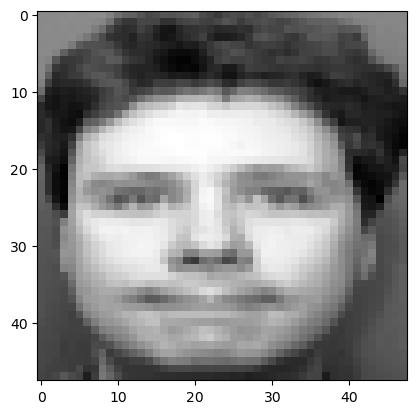

In [49]:
img = random.choice(Featur_X_train)
plt.imshow(img, cmap='gray')

In [50]:
Featur_X_test = create_features(X_test)
Featur_X_test.shape

(80, 48, 48, 1)

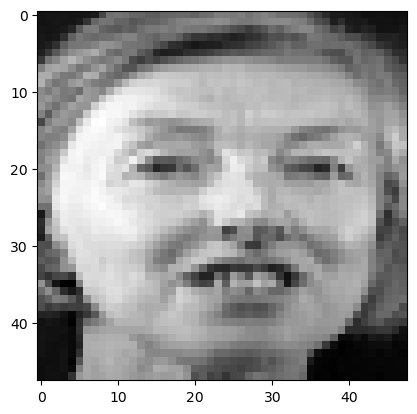

In [51]:
img = random.choice(Featur_X_test)
plt.imshow(img, cmap='gray')

In [58]:
WFE_model = create_model()
WFE_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam' )

In [59]:
WFE_history = WFE_model.fit(Featur_X_train, y_train, batch_size=8 , 
                            epochs=150, 
                            validation_data = (Featur_X_test, y_test))

Epoch 1/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0282 - loss: 3.7067 - val_accuracy: 0.0125 - val_loss: 3.6903
Epoch 2/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0306 - loss: 3.6851 - val_accuracy: 0.0250 - val_loss: 3.6915
Epoch 3/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0445 - loss: 3.6509 - val_accuracy: 0.0375 - val_loss: 3.6105
Epoch 4/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1093 - loss: 3.5403 - val_accuracy: 0.1625 - val_loss: 3.1049
Epoch 5/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2041 - loss: 2.9365 - val_accuracy: 0.3500 - val_loss: 2.4446
Epoch 6/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3396 - loss: 2.2750 - val_accuracy: 0.7375 - val_loss: 1.3770
Epoch 7/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4950 - loss: 1.5585 - val_accuracy: 0.7875 - val_loss: 0.9891
Epoch 8/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6419 - loss: 1.2784 - val_accuracy: 0.8125 - 

In [55]:
def plot_performance(history):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val loss evolution')

    plt.subplot(2, 1, 2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val accuracy')

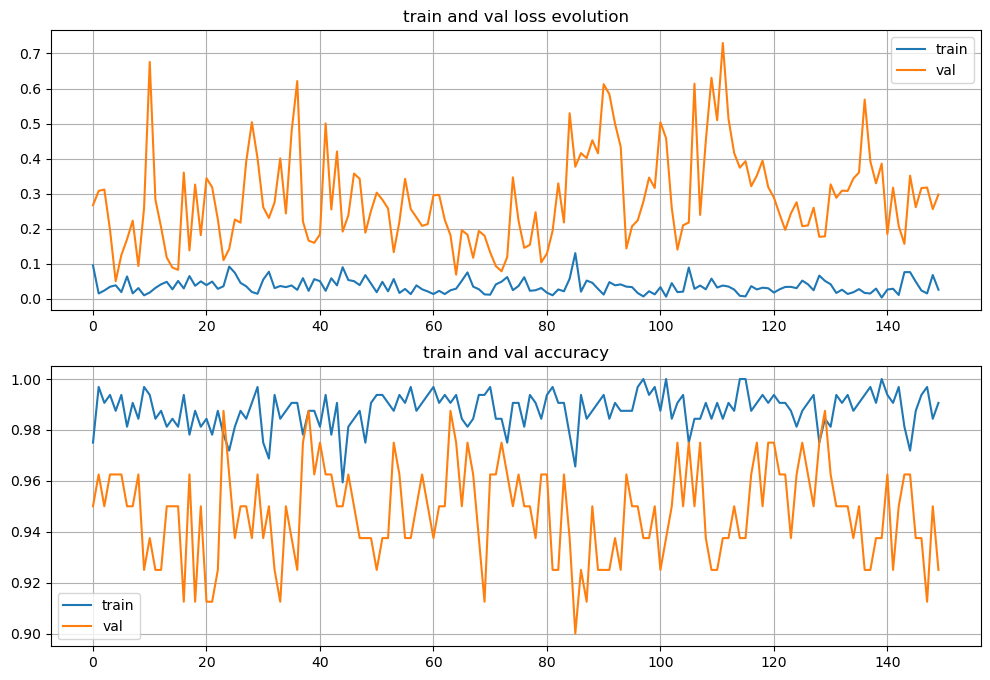

In [56]:
plot_performance(WFE_history)

In [29]:
WFE_acc = WFE_model.evaluate(Featur_X_test, y_test, verbose = 0)[1]
print("Accuracy :",WFE_model.evaluate(Featur_X_test, y_test, verbose = 0)[1])

Accuracy : 0.987500011920929


In [31]:
from sklearn.metrics import classification_report
y_pred = WFE_model.predict(X)
y_pred_encoded = np.argmax(y_pred, axis = 1)
Report = classification_report(Y, y_pred_encoded)
print(Report)

ValueError: in user code:

    C:\Users\BENRADI\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\Users\BENRADI\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\BENRADI\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\BENRADI\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\BENRADI\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\BENRADI\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    C:\Users\BENRADI\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    C:\Users\BENRADI\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\BENRADI\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:191 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: [None, 112, 92]


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from  shutil import copyfile
import random
import zipfile
import tensorflow as tf

(1, 24, 24, 6)
(1, 24, 24, 16)
(1, 12, 12, 16)
(1, 10, 10, 64)
(1, 5, 5, 64)
(1, 1600)
(1, 128)
(1, 128)
(1, 40)


C:\Users\BENRADI\AppData\Local\Temp/ipykernel_8220/1133613961.py:49: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std ()
C:\Users\BENRADI\AppData\Local\Temp/ipykernel_8220/1133613961.py:49: RuntimeWarning: divide by zero encountered in true_divide
  x /= x.std ()


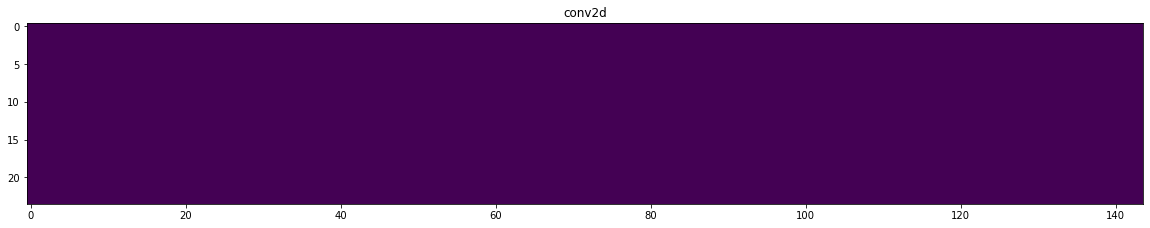

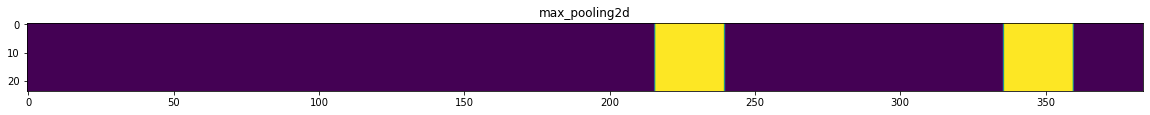

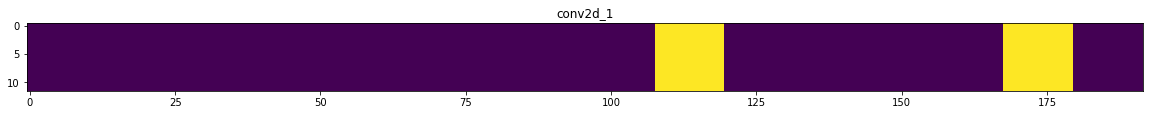

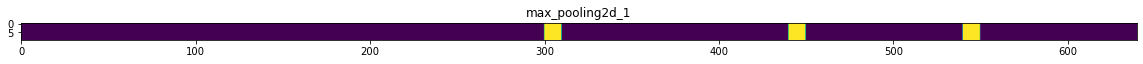

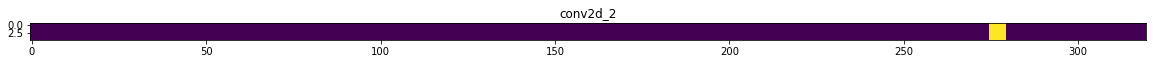

In [34]:
successive_outputs = [layer.output for layer in WFE_model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = WFE_model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
#cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
#dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

#img_path = random.choice(cat_img_files + dog_img_files)

img = random.choice(Featur_X_test)   # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in WFE_model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 